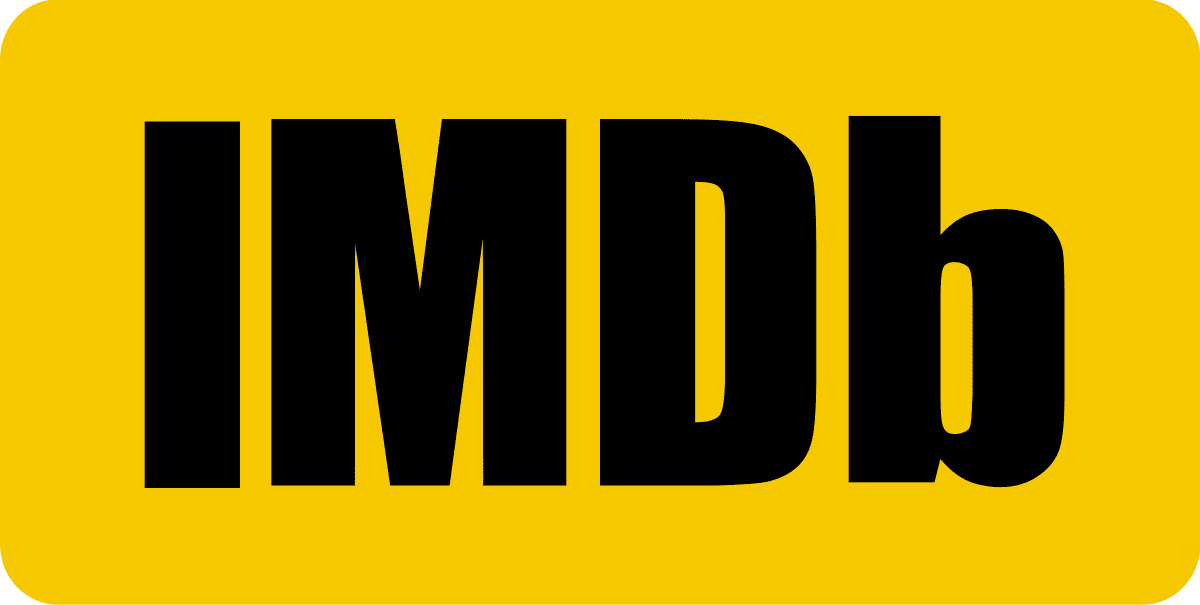

IMDb, the Internet Movie Database, is on of the premier websites for film and television information. The site is extraordinarily comprehensive in the data it makes available for video media, from cast and crew information to financial data.

[Statista](https://www.statista.com/statistics/899009/reading-reviews-before-viewing-movie-united-states-by-age/) data shows that about 2/3 of U.S. adults utilize reviews to influence their decision to see a movie. Reviews can contain spoilers, information that reveals important plot details or surprises about the film, which can affect the consumer's enjoyment of the film or even influence their decision to not go see it. While some websites specialize in movie spoilers for users that seek that information, sites like IMDb strive to keep that content censored to instill confidence in the user base that they will not be presented with spoilers.

The current IMDb model for dealing with spoiler content relies on user self-censorship. There is a reporting feature allows users to flag spoilers but no system which can prevent spoilers from being public. An automated censoring system can free resources to focus on other problems on the site and increase the trust users have they can browse without seeing spoilers. The goal of this project is to evaluate the use of natural language processing, a field of machine learning, in categorizing text as containing a spoiler or not. 

# Imports

In [2]:
import pandas as pd
import numpy as np
import re
import string
import json
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from langdetect import detect
import spacy

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, precision_score

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

_________________
**Helper Functions**

In [3]:
def confusion_matrix_plot(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()

def report(y_true, y_pred, class_names=['no_spoiler', 'spoiler']):
    print(classification_report(y_true, y_pred, target_names=class_names))
    confusion_matrix_plot(y_true, y_pred, class_names)

_________
Skip to section 2.3 to load the merged dataframe after initial EDA and processing. Then all cells in the remainder of section 2 and beyond can be executed.

# EDA

The data comes in two json files: IMDB_movie_details.json and IMDB_reviews.json. The project will mainly be concerned with the reviews themselves but we should take a look at the movie details also to see what data we have access to.

## Movie Details

In [3]:
movie_details = pd.read_json('./data/IMDB_movie_details.json', lines=True)
display(movie_details.info())
movie_details

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   release_date   1572 non-null   object 
 6   plot_synopsis  1572 non-null   object 
dtypes: float64(1), object(6)
memory usage: 86.1+ KB


None

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...
...,...,...,...,...,...,...,...
1567,tt0289879,Evan Treborn grows up in a small town with his...,1h 53min,"[Sci-Fi, Thriller]",7.7,2004-01-23,"In the year 1998, Evan Treborn (Ashton Kutcher..."
1568,tt1723811,Brandon is a 30-something man living in New Yo...,1h 41min,[Drama],7.2,2012-01-13,"Brandon (Michael Fassbender) is a successful, ..."
1569,tt5013056,Evacuation of Allied soldiers from the British...,1h 46min,"[Action, Drama, History]",8.1,2017-07-21,The film alternates between three different pe...
1570,tt0104014/,"For a while now, beautiful 24-year-old Diana B...",1h 33min,"[Comedy, Drama]",5.3,1992-02-21,


It looks like we have the IMDB movie_id, a plot summary, duration, genre (list), rating, release date, and plot synopsis for the films. There are 1572 of them. All but the rating were imported as objects, but we can convert the duration and release time into an integer and date-time object respectively.
_________________
Convert 'release_date' to a datetime object

In [4]:
movie_details['release_date'] = pd.to_datetime(movie_details.release_date)

Convert duration into a minute count (integer)

In [5]:
hour = re.compile('(\d+)h')
minute = re.compile('(\d+)min')

def duration_convert(df):
    # set intial duration to 0
    duration = 0
    # find number of hours and minutes
    hour_found = hour.findall(df.duration)
    minute_found = minute.findall(df.duration)
    # if hours, multiply value by 60 and add to duration
    if hour_found:
        duration += 60 * int(hour_found[0])
    # if minutes, add to duration
    if minute_found:
        duration += int(minute_found[0])
    # return total number of minutes
    return duration

movie_details['duration'] = movie_details.apply(duration_convert, axis=1)

_______
Here we want to confirm that all the genre fields contains lists, for possible future genre analysis.

In [6]:
for i in list(range(len(movie_details))):
    count = 0
    if str(type(movie_details.iloc[i].genre)) != "<class 'list'>":
        count += 1
        print(type(movie_details.iloc[i].genre))
print(f"There are {count} entries for genre that are not a list")

There are 0 entries for genre that are not a list


____________
We noticed some of the movie_ids have a trailing forward slash, we need to fix that to merge the data because the movie reviews data will contain the movie_id

In [7]:
def fix_movie_id(df):
    if df.movie_id[-1] == '/':
        return  df.movie_id[:-1]
    else:
        return df.movie_id

movie_details['movie_id'] = movie_details.apply(fix_movie_id, axis=1)

____________

In [8]:
movie_details.describe(datetime_is_numeric=True)

,duration,rating,release_date
count,1572.000000,1572.000000,1572
mean,115.269084,7.071819,2001-06-20 14:17:24.274809216
min,42.000000,2.400000,1921-02-06 00:00:00
25%,100.000000,6.500000,1995-08-23 06:00:00
50%,113.000000,7.100000,2003-07-05 12:00:00
75%,128.000000,7.800000,2010-12-04 18:00:00
max,321.000000,9.500000,2018-02-15 00:00:00
std,24.544471,0.967966,NaN


The numerical data for our films being reviews shows:
- Average film is 115 minutes, with a range of 42 to 321 minutes
- Average rating is a 7, with a range from 2.4 to 9.5
- The oldest film is from 1921, but the vast majority are released after 1995

### plot summary / synopsis

One consideration we have is comparing the review to the plot of the film. In our movie details, we have access to a plot summary and plot synopsis, but we need to figure out which one to use.

In [9]:
# checking on the number of empty values
empty_summary = len(movie_details[movie_details.plot_summary == ''])
empty_synopsis = len(movie_details[movie_details.plot_synopsis == ''])
print(f"There are {empty_summary} entries with an empty summary.\nThere are {empty_synopsis} entries with an empty synopsis.")
print("------------------------------")
# looking at the average character count for each feature
total_films = len(movie_details)
films_no_synopsis = total_films - 233
summary_char_count = 0
synopsis_char_count = 0
for i, v in enumerate(movie_details.values):
    summary_chars = len(v[1])
    synopsis_chars = len(v[-1])
    summary_char_count += summary_chars
    synopsis_char_count += synopsis_chars
print(f"The average character count for summary is: {round(summary_char_count/total_films, 2)}")
print(f"The average character count for synopsis is: {round(synopsis_char_count/films_no_synopsis, 2)}")

There are 0 entries with an empty summary.
There are 233 entries with an empty synopsis.
------------------------------
The average character count for summary is: 614.26
The average character count for synopsis is: 9644.49


It would be best to use the film synopsis as it is longer and will contain more detail about the film, but we are missing 233 synopses from the data. With that many missing, we will use the film summary instead of synopsis if we explore cosine similarity as an approach to spoiler detection. For that purpose we have saved a list containing the movie_ids for the films with missing synopsis.

In [10]:
no_synopsis_ids = list(movie_details[movie_details.plot_synopsis == '']['movie_id'])

with open('no_synopsis_ids.pkl', 'wb') as f:
    pickle.dump(no_synopsis_ids, f)

# load the saved list of indicies
# with open('no_synopsis_ids.pkl', 'rb') as f:
#     no_synopsis_ids = pickle.load(f)

## Movie Reviews

In [10]:
movie_reviews = pd.read_json('./data/IMDB_reviews.json', lines=True)
display(movie_reviews.info())
movie_reviews

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB


None

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"
...,...,...,...,...,...,...,...
573908,8 August 1999,tt0139239,ur0100166,False,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties
573909,31 July 1999,tt0139239,ur0021767,False,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie
573910,20 July 1999,tt0139239,ur0392750,False,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen
573911,11 June 1999,tt0139239,ur0349105,False,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?


In this dataset we have 573,913 reviews, with data on the review date, the corresponding movie_id, the user_id of the reviewer, the target **is_spoiler** labeling the review as a spoiler or not, the review text, the user rating, and the review_summary.
____________
First, lets check that our movie_ids match up by comparing the sets of the movie_ids from both dataframes.

In [11]:
set(list(movie_details['movie_id'])) == set(list(movie_reviews['movie_id']))

True

We need to convert review_date to datetime like we did in movie details and we need to convert the target to a numerical feature.

In [12]:
movie_reviews['review_date'] = pd.to_datetime(movie_reviews.review_date)
movie_reviews['is_spoiler'] = movie_reviews.is_spoiler.astype(int)

In [13]:
movie_reviews.describe(datetime_is_numeric=True)

,review_date,is_spoiler,rating
count,573913,573913.000000,573913.000000
mean,2009-07-20 04:42:25.548193280,0.262974,6.954254
min,1998-07-28 00:00:00,0.000000,1.000000
25%,2005-06-18 00:00:00,0.000000,5.000000
50%,2009-07-25 00:00:00,0.000000,8.000000
75%,2014-05-15 00:00:00,1.000000,10.000000
max,2018-01-07 00:00:00,1.000000,10.000000
std,NaN,0.440249,2.956295


Initial insights from the numerical data:
- The reviews are mostly from 2005 and later
- The user rating is, on average, the same as the metadata rating. The range is larger, from 1 to 10
- The mean for is_spoiler is 0.2629, which should correspond to the percentage of reviews that contain spoilers (1)
________________
Lets explore the reviews a bit deeper

### Character and word counts

We did have interest in character and word counts of the reviews, which we originall processed with entity extraction. Lets include those features here. (the processing takes about 10 minutes)

In [14]:
def char_word_count(row):
    # get the review text
    review = row.review_text
    # generate new features for character and word count of the review
    row['review_char_count'] = len(review)
    row['review_word_count'] = len(review.split(' '))
    # return the row
    return row

movie_reviews = movie_reviews.apply(char_word_count, axis=1)

We initially had interest in entitiy extraction to compare reviews with spoilers to those without. This processing takes just under 8 hours for the review text, much shorter for the synopsis text. The functions were manually changed to pull the correct text when performing the same processing on the synopsis text. In the end, entity extraction was not something tha panned out but we did not want to delete the code. The processed dataframe was saved as full_dataframe.parquet if we wanted to look at it later.

In [ ]:
# nlp = spacy.load('en_core_web_sm')

# def entity_info(row):
#     # get the review text
#     review = row.review_text
#     # generate new features for character and word count
#     row['char_count'] = len(review)
#     row['word_count'] = len(review.split(' '))
#     # get the entities with spacy
#     doc = nlp(review)
#     # initialize list of entities and their counts
#     ent_list = []
#     ent_count = []
#     # append each entity to the list of entities
#     for ent in doc.ents:
#         ent_list.append(ent.text)
#     # generate the set of unique entities
#     ent_set = set(ent_list)
#     # append a tuple to ent_count with each found entity and its count
#     for ent in ent_set:
#         ent_count.append((ent, ent_list.count(ent)))
#     # set number of unique entities and initialize the total count to 0
#     unique_ents = len(ent_count)
#     unique_ent_count = 0
#     # for each tuple, add the count from the entity frequency to the total count
#     for x in ent_count:
#         unique_ent_count += x[1]
#     # get the average count for an entity
#     if unique_ents != 0:
#         avg_count = round(unique_ent_count / unique_ents, 2)
#     else:
#         avg_count = 0
#     # generate new features for the total entity count, unique count, and avg frequency
#     row['entity_count'] = len(ent_list)
#     row['unique_entities'] = unique_ents
#     row['avg_entity_freq'] = avg_count
#     # return the row
#     return row

# movie_reviews = movie_reviews.apply(entity_info, axis=1)

# summary_stopwords = stopwords.words('english')
# pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
# tokenizer = RegexpTokenizer(pattern)

# def review_tokenize(row):
#     # get the film review
#     review = row.review_text
#     # tokenize
#     review_tokens = tokenizer.tokenize(review)
#     review_tokens = [token.lower() for token in review_tokens]
#     review_tokens = [token for token in review_tokens if token not in summary_stopwords]
#     # set new feature to token list
#     row['review_tokens'] = review_tokens
#     row['review_token_count'] = len(review_tokens)
#     return row

# movie_reviews = movie_reviews.apply(review_tokenize, axis=1)

# merged_df = pd.merge(movie_details, movie_reviews, on='movie_id', how="right")

# corrected_columns = ['movie_id', 'plot_summary', 'duration', 'genre', 'film_rating',
#                      'release_date', 'plot_synopsis', 'summary_char_count',
#                      'summary_word_count', 'summary_entity_count', 'summary_unique_entities',
#                      'summary_avg_entity_freq', 'summary_tokens', 'summary_token_count',
#                      'review_date', 'user_id', 'is_spoiler', 'review_text', 'reviewer_rating',
#                      'review_summary', 'review_char_count', 'review_word_count', 'review_entity_count',
#                      'review_unique_entities', 'review_avg_entity_freq', 'review_tokens',
#                      'review_token_count']

# merged_df.columns = corrected_columns

# merged_df.to_parquet('./data/full_dataframe.parquet')

### Review language

We want to ensure that all our reviews are English. We can do that with the help of a package called langdetect

In [17]:
# def non_english_review(df):
#     review = df.review_text
#     if detect(review) != 'en':
#         return 1
#     else:
#         return 0

# this takes about an hour and a half
# movie_reviews['non_english_review'] = movie_reviews.apply(non_english_review, axis=1)

# pulling the index values of those entries with non-english reviews
# non_english_reviews = list(merged_df[merged_df.non_english_review == 1].index)

# going to save this to a pickle file to load later if necessary
# with open('./pickle/non_english_reviews.pkl', 'wb') as f:
#     pickle.dump(non_english_reviews, f)

# load the saved list of indicies
with open('./pickle/non_english_reviews.pkl', 'rb') as f:
    non_english_reviews = pickle.load(f)

# look at how many non-english reviews we have
print(f"Number of non-english reviews: {len(non_english_reviews)}")

Number of non-english reviews: 53


With so few non-english reviews, we will remove them from consideration in modeling.

In [18]:
movie_reviews.drop(non_english_reviews, inplace=True)
movie_reviews.reset_index(drop=True, inplace=True)

## Merge data

We will merge the two dataframes into one containing all the reivews and matching up the movie details for each review. We will then save this as 'merged_data.parquet' for easer loading. This dataframe has already dropped the non-english reviews and converted all the datatypes correctly

In [4]:
# merged_df = pd.merge(movie_details, movie_reviews, on='movie_id', how='right')
# merged_df.to_parquet('./data/merged_data.parquet')
merged_df = pd.read_parquet('./data/merged_data.parquet')

This cell reads in the full dataframe from the saved parquet file. The file is large, 573,913 entries with 27 features including the entitiy extraction (that wasn't utilized in analysis) and takes up about 1.9 GB of space. The load takes about a minute. We did not need much of this file, just the review

In [20]:
# merged_df = pd.read_parquet('./data/full_dataframe.parquet')
# set the is_spoiler target to integer values
# merged_df['is_spoiler'] = merged_df.is_spoiler.astype(int)

# Exploring reviews

## Word count

In [5]:
merged_df.review_word_count.describe()

count    573860.000000
mean        259.414927
std         195.438140
min           1.000000
25%         131.000000
50%         189.000000
75%         322.000000
max        2673.000000
Name: review_word_count, dtype: float64

In [5]:
outlier_wc = round(merged_df.review_word_count.mean() + (3 * merged_df.review_word_count.std()),)
print("Upper outlier boundary for word count:", outlier_wc)
print("Lower 2.5% reviews word count:", merged_df.review_word_count.quantile(0.025))
print("Upper 2.5% reviews word count:", merged_df.review_word_count.quantile(0.975))

Upper outlier boundary for word count: 846
Lower 2.5% reviews word count: 54.0
Upper 2.5% reviews word count: 848.0


We saw that our minimum review word count is 1, and our maximum is 2673, but our average is just about 260 words. Defining outliers as 3x the std from the mean, we would not have any lower bound outliers, and our upper bound outliers would be 846 words. Our bottom 2.5% of reviews contains fewer words than 54 and our upper 2.5% contain more words than 848, which is close to the threshold we calculated for outliers.

54 words is still quite a few and our model may see value in reviews with that many words, but there may not be value in reviews that are really short.

Lets explore restricting reviews by length by looking at the counts for reviews with low word counts. We can modify the max_count value in this next cell to get the frequency by word count, total, and the indicies of all the reviews in question for easy removal

In [6]:
total = 0
min_count = 1
max_count = 54
review_indices = []

for x in range(min_count,max_count+1):
    df = merged_df[merged_df.review_word_count == x]
    indices = list(df.index)
    review_indices.extend(indices)
    count = len(df)
    total += count
#     print(f"Reviews with {x} words: {count}")
print(f"There are {total} reviews containing {max_count} or fewer words.")

There are 14489 reviews containing 54 or fewer words.


In [7]:
merged_df.iloc[review_indices].is_spoiler.value_counts()

0    14194
1      295
Name: is_spoiler, dtype: int64

The smaller reviews only contain about 2% spoilers, not very many but we already have a minority of that class.
_____
Let's look at the reviews with large word counts.

In [8]:
total = 0
min_count = 846
max_count = 2673
review_indices = []

for x in range(min_count,max_count+1):
    df = merged_df[merged_df.review_word_count == x]
    indices = list(df.index)
    review_indices.extend(indices)
    count = len(df)
    total += count
#     if count > 0:
#         print(f"Reviews with {x} words: {count}")
print(f"There are {total} reviews containing {min_count} or more words.")

There are 14518 reviews containing 846 or more words.


In [9]:
merged_df.iloc[review_indices].is_spoiler.value_counts()

1    7437
0    7081
Name: is_spoiler, dtype: int64

The larger reviews unfortunately contain a small majority of spoilers, much more by percent than our whole dataset. 

For now we will not do any data retriction based on word count of the review but it was something interesting to explore

## WordCloud

In later sections we preprocessed the review text by lemmatizing it. Here, we load the review dataframe with the target and the lemmed review text to genereate word clouds: one for spoiler reviews, one for non-spoilers

In [10]:
review_df = pd.read_parquet('./data/reviews_lemmed.parquet', columns=['is_spoiler', 'review_text_lemmed'])

In [11]:
spoiler_words = review_df[review_df.is_spoiler == 1]['review_text_lemmed'].str.cat(sep=' ')
non_spoiler_words = review_df[review_df.is_spoiler == 0]['review_text_lemmed'].str.cat(sep=' ')

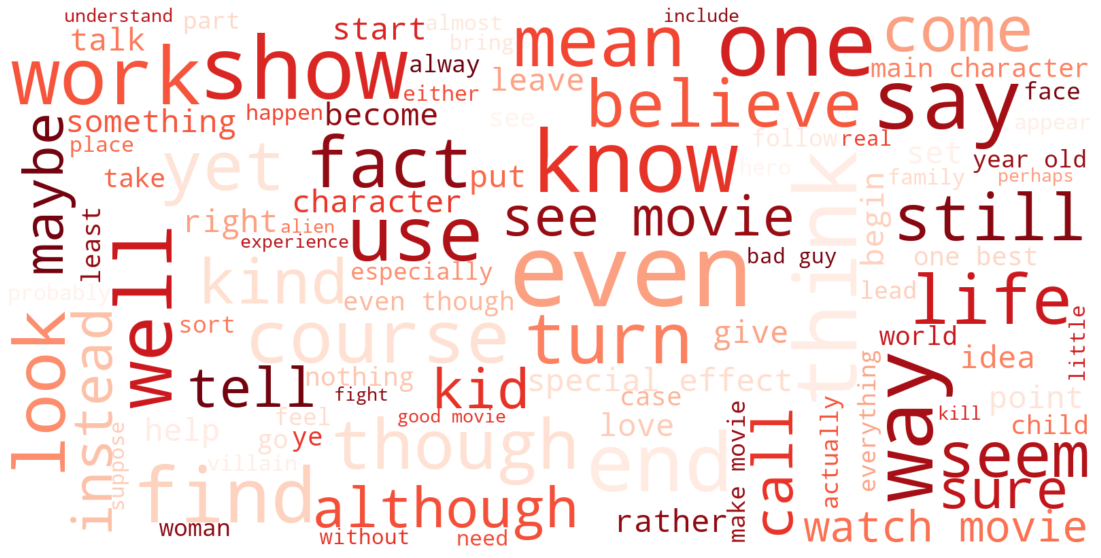

In [123]:
spoiler_wordcloud = WordCloud(max_font_size=150, max_words=100, 
                              background_color='white', colormap='Reds',
                              width=1600, height=800).generate(spoiler_words)

plt.figure(figsize=(20,10))
plt.imshow(spoiler_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [124]:
spoiler_wordcloud.to_file('./img/spoiler_wordcloud.png')

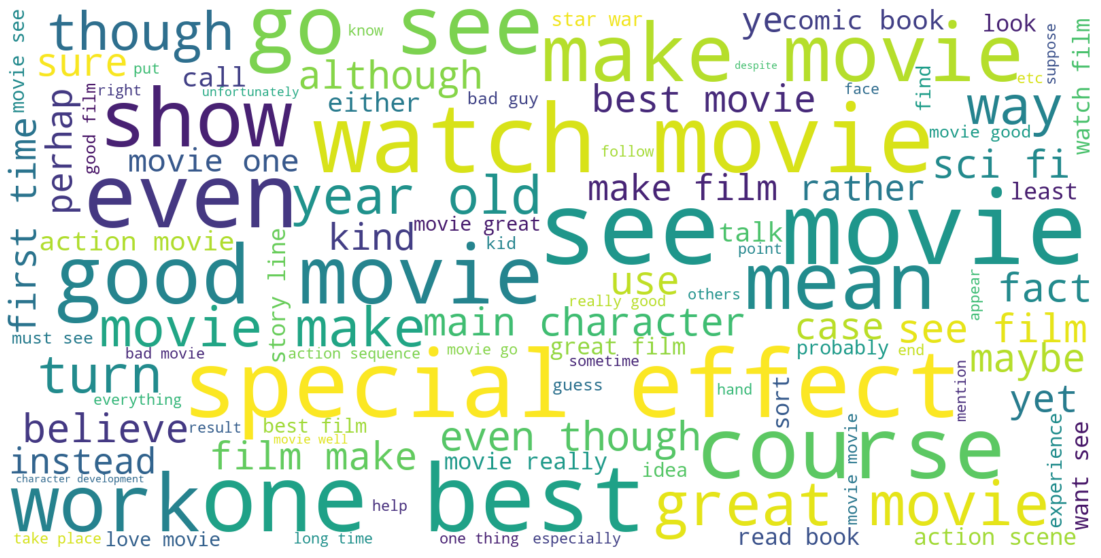

In [125]:
non_spoiler_wordcloud = WordCloud(max_font_size=150, max_words=100,
                                  background_color='white',
                                  width=1600, height=800).generate(non_spoiler_words)

plt.figure(figsize=(20,10))
plt.imshow(non_spoiler_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [126]:
non_spoiler_wordcloud.to_file('./img/non_spoiler_wordcloud.png')

Initial reactions to the word clound:
- the spoiler cloud seems to contain more words about knowledge and belief, likely containing information cruicial to the plot
- the non-spoiler reviews seem to contain more quality and evaluative text, recommendations and feelings about it

## Spoiler Frequency

In [10]:
merged_df[merged_df.is_spoiler == 1].describe()

,duration,rating_x,is_spoiler,rating_y,review_char_count,review_word_count
count,150909.000000,150909.000000,150909.0,150909.000000,150909.000000,150909.000000
mean,121.128488,7.280335,1.0,6.517444,1887.806353,334.917997
std,24.940509,0.948578,0.0,3.015920,1283.836091,223.268510
min,42.000000,2.400000,1.0,1.000000,50.000000,8.000000
25%,105.000000,6.700000,1.0,4.000000,920.000000,166.000000
50%,119.000000,7.400000,1.0,7.000000,1459.000000,261.000000
75%,136.000000,8.000000,1.0,9.000000,2456.000000,435.000000
max,321.000000,9.500000,1.0,10.000000,14302.000000,2565.000000


In [11]:
merged_df[merged_df.is_spoiler == 0].describe()

,duration,rating_x,is_spoiler,rating_y,review_char_count,review_word_count
count,422951.000000,422951.000000,422951.0,422951.000000,422951.000000,422951.000000
mean,120.942258,7.298362,0.0,7.109942,1308.228097,232.475417
std,25.483269,0.963061,0.0,2.918918,1021.058027,176.857874
min,42.000000,2.400000,0.0,1.000000,18.000000,1.000000
25%,104.000000,6.700000,0.0,5.000000,682.000000,124.000000
50%,118.000000,7.400000,0.0,8.000000,947.000000,171.000000
75%,135.000000,8.000000,0.0,10.000000,1575.000000,280.000000
max,321.000000,9.500000,0.0,10.000000,14963.000000,2673.000000


Initial observations from the describe calls on reviews marked as spoiler versus ones that are not:
- The reviewer rating (rating_y) is about half a point lower on average for reviews marked as spoilers
- The review word count of a spoiler review is longer on average by about 36% (232 -> 335), but does have a more variation
- Rougly the same can be said about the character counts.
- Spoiler and non-spoiler reviews both average about 5.6 characters per word

It looks like there is nothing glaringly obvious about the difference between spoiler and non-spoiler reviews in terms of word counts

In [43]:
merged_df.is_spoiler.value_counts(normalize=True)

0    0.737028
1    0.262972
Name: is_spoiler, dtype: float64

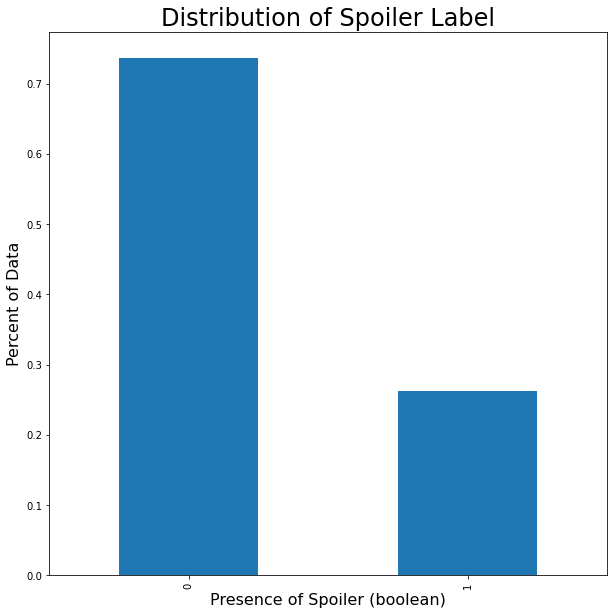

In [110]:
fig, ax = plt.subplots(figsize=(10,10))

merged_df.is_spoiler.value_counts(normalize=True).plot(kind='bar', ax=ax)
# merged_df.groupby('is_spoiler').size().plot(kind='bar', ax=ax)
ax.set_xlabel('Presence of Spoiler (boolean)', fontsize=16)
ax.set_ylabel('Percent of Data', fontsize=16)
ax.set_title('Distribution of Spoiler Label', fontsize=24)

plt.savefig('./img/spoiler_distribution.png', dpi=300)
plt.show();

## Spoiler by genre

Looking at spoiler distribution by genre.

In [55]:
genres = merged_df[['genre', 'is_spoiler']].explode('genre').copy()
genres = genres.groupby(['genre', 'is_spoiler']).size().unstack()
genres.reset_index(inplace=True)
genres.columns = ['Genre', 'No_spoiler', 'Spoiler']
# generate a feature for percent of reviews spoiler
genres['percent_spoiler'] = genres['Spoiler'] / (genres['No_spoiler'] + genres['Spoiler'])

,Genre,No_spoiler,Spoiler,percent_spoiler
16,Sci-Fi,65723,29823,0.312132
11,Horror,32902,13879,0.296680
14,Mystery,45505,18538,0.289462
1,Adventure,133550,53728,0.286889
0,Action,136812,53892,0.282595
8,Fantasy,55398,21689,0.281357
18,Thriller,68447,26769,0.281140
9,Film-Noir,1303,488,0.272473
7,Family,28854,10701,0.270535
2,Animation,19763,6833,0.256918


In [58]:
genre_order = sorted(list(genres.Genre))

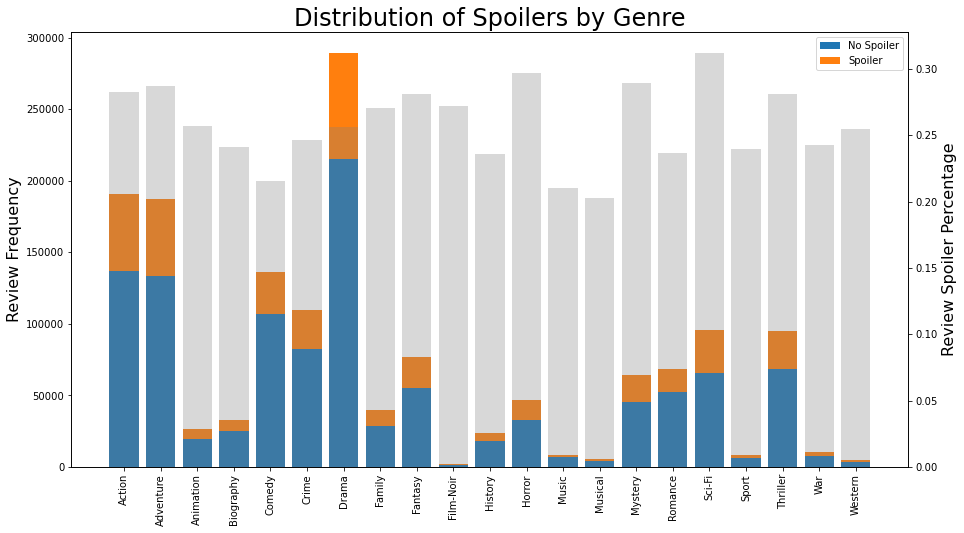

''

In [116]:
fig, ax = plt.subplots(figsize=(15,8))

ax.bar(genre_order, genres['No_spoiler'], label='No Spoiler')
ax.bar(genre_order, genres['Spoiler'], bottom=genres.No_spoiler, label='Spoiler')
# ax.set_xlabel('Genres', fontsize=16)
plt.xticks(rotation=90)
ax.set_ylabel('Review Frequency', fontsize=16)
plt.legend()

ax2 = ax.twinx()
ax2.bar(genre_order, genres['percent_spoiler'], color='grey', alpha=0.3, label='Percent')
ax2.set_ylabel('Review Spoiler Percentage', fontsize=16)

plt.title('Distribution of Spoilers by Genre', fontsize=24)

plt.savefig('./img/spoilers_by_genre.png', dpi=300)
plt.show();

It's interesting that the spoiler percentage is relatively homogenous. Despite large difference in raw review count, the presence of spoilers is between 20 and 31 percent. Genres with the highest percentage of spoilers are: Sci-Fi, Horror and Mystery; the lowest are Comedy, Music and Musical. 

This makes some sense, horror and mystery films often have plot twists or big reveals (like the killer's identity). Sci-Fi films also tend to have fantastical elements that can be spoiled. Comedy and musical films tend to not have such major plot points for spoiling.

## Spoilers by UserID

Exploring spoilers by user_id

In [145]:
user_ids = merged_df[['user_id', 'is_spoiler']].copy()
user_ids = user_ids.groupby(['user_id', 'is_spoiler']).size().unstack()
user_ids.reset_index(inplace=True)
user_ids.columns = ['user_id', 'No_spoiler', 'Spoiler']
# fill the NaNs with 0.0
user_ids['No_spoiler'] = user_ids['No_spoiler'].fillna(0.0)
user_ids['Spoiler'] = user_ids['Spoiler'].fillna(0.0)
# generate a feature for total reviews
user_ids['total_reviews'] = user_ids['No_spoiler'] + user_ids['Spoiler']
# generate a feature for percent of reviews spoiler
user_ids['percent_spoiler'] = user_ids['Spoiler'] / (user_ids['total_reviews'])
user_ids.describe()

,No_spoiler,Spoiler,total_reviews,percent_spoiler
count,263362.000000,263362.000000,263362.000000,263362.000000
mean,1.605968,0.573010,2.178978,0.252159
std,8.537301,5.080272,10.666659,0.413914
min,0.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.500000
max,1283.000000,1019.000000,1303.000000,1.000000


In [155]:
len(user_ids[user_ids.percent_spoiler == 0.0]) / len(user_ids)

0.699933931242928

In [158]:
user_ids[user_ids.percent_spoiler == 0.0].describe()

,No_spoiler,Spoiler,total_reviews,percent_spoiler
count,184336.000000,184336.0,184336.000000,184336.0
mean,1.478344,0.0,1.478344,0.0
std,3.148141,0.0,3.148141,0.0
min,1.000000,0.0,1.000000,0.0
25%,1.000000,0.0,1.000000,0.0
50%,1.000000,0.0,1.000000,0.0
75%,1.000000,0.0,1.000000,0.0
max,447.000000,0.0,447.000000,0.0


In [157]:
user_ids[user_ids.percent_spoiler > 0.0].describe()

,No_spoiler,Spoiler,total_reviews,percent_spoiler
count,79026.000000,79026.000000,79026.000000,79026.000000
mean,1.903665,1.909612,3.813277,0.840345
std,14.820784,9.135641,18.768178,0.276906
min,0.000000,1.000000,1.000000,0.002513
25%,0.000000,1.000000,1.000000,0.666667
50%,0.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000
max,1283.000000,1019.000000,1303.000000,1.000000


There are 263,362 unique users represented in the data. We can see that the vast majority do not comment more than once; the average number of reviews per user is 2.17. 

Most of our users (70%) do not spoil at all. Of those that don't spoil, the average user reviews 1.47 times.

Users who spoil leave more reviews on average (3.81). Most users who spoil do so almost exclusively, but not in large volume. There do appear to be some serial spoilers in our user base though.
___________________
Lets look at our top 20 commenters.

In [146]:
top_20 = user_ids.sort_values(by='total_reviews', ascending=False)[:20]
top_20

,user_id,No_spoiler,Spoiler,total_reviews,percent_spoiler
137508,ur2898520,1283.0,20.0,1303.0,0.015349
173142,ur4248714,2.0,1019.0,1021.0,0.998041
16295,ur0453068,735.0,71.0,806.0,0.088089
217117,ur60028700,3.0,767.0,770.0,0.996104
96018,ur20552756,742.0,13.0,755.0,0.017219
190548,ur4888011,658.0,43.0,701.0,0.061341
122125,ur2488512,616.0,65.0,681.0,0.095448
47314,ur1234929,670.0,10.0,680.0,0.014706
51158,ur1293485,493.0,167.0,660.0,0.253030
17234,ur0482513,331.0,310.0,641.0,0.483619


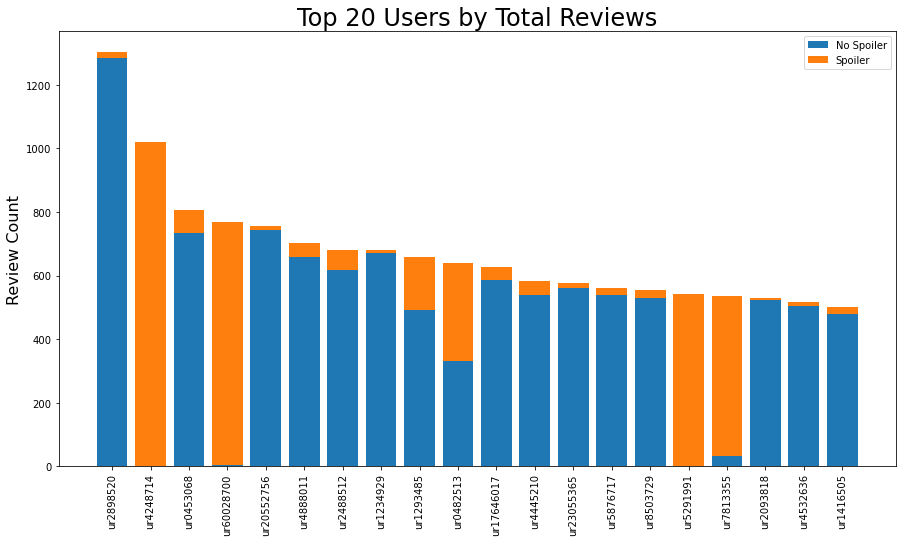

''

In [163]:
fig, ax = plt.subplots(figsize=(15,8))

ax.bar(top_20['user_id'], top_20['No_spoiler'], label='No Spoiler')
ax.bar(top_20['user_id'], top_20['Spoiler'], bottom=top_20.No_spoiler, label='Spoiler')
# ax.set_xlabel('Genres', fontsize=16)
plt.xticks(rotation=90)
ax.set_ylabel('Review Count', fontsize=16)
plt.legend()

plt.title('Top 20 Users by Total Reviews', fontsize=24)

plt.savefig('./img/spoilers_by_user.png', dpi=300)
plt.show();

The twenty users with the largest raw number of reviews illuminates the problem: there are users who almost exclusively write reviews that spoil the film. It should be possible to implement a trigger in the moderation system that punishes users that submit a high percentage of reviews that contain spoilers.

# Non-language feature modeling

We thought it would be interesting to model using the non-language features of our data. Features which don't pertain to the summary or review text include:
- film duration
- genre
- rating
- release date
- review date
- is_spoiler (target)

In [23]:
non_lang_features = ['duration', 'genre', 'film_rating', 'release_date', 'review_date',
                     'is_spoiler']
non_language_df = merged_df[non_lang_features].copy()

Engineer a new feature: age of film at review

In [24]:
def film_age(df):
    age = df.review_date - df.release_date
    return age.days

non_language_df['days_since_release'] = non_language_df.apply(film_age, axis=1)
non_language_df.drop(['release_date', 'review_date'], axis=1, inplace=True)

Explode the genres. [Inspiration](https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list)

In [25]:
s = non_language_df['genre'].explode()
non_language_df = non_language_df[['duration', 'film_rating', 'is_spoiler',
                                   'days_since_release']].join(pd.crosstab(s.index, s))

## SGD Classifier

We are going to try using a SGD classifer to see how well it performs

In [26]:
# set X and y
X = non_language_df.drop('is_spoiler', axis=1)
y = non_language_df['is_spoiler']

# perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# scale the predictors
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

Performing a grid search for optimized parameters. This runs in about 18 minutes, so it's commented out and the best parameters are listed below

In [27]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
}

clf = SGDClassifier(max_iter=1000)
grid = GridSearchCV(clf, param_grid=params, cv=10, n_jobs=-1)

# grid.fit(X_train, y_train)

# print(grid.best_params_)

Best params were:
- alpha: 0.0001
- loss: 'hinge'
- penalty: 'l2'

In [28]:
sgd_model = SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2')
sgd_model.fit(X_train_s, y_train)

SGDClassifier()

In [29]:
y_pred = sgd_model.predict(X_test_s)

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     84696
     spoiler       0.00      0.00      0.00     30076

    accuracy                           0.74    114772
   macro avg       0.37      0.50      0.42    114772
weighted avg       0.54      0.74      0.63    114772



C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


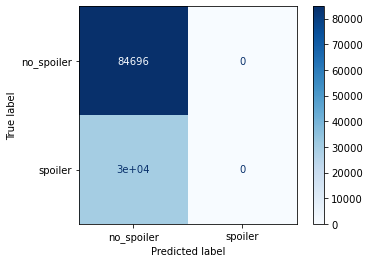

In [30]:
report(y_test, y_pred)

Modeling on the film review metadata we have does not look promising.
________
We will move on to the primary interest: the reviews themselves.

# Data Preparation

For bag of words modeling we only need the review text and the target. We will keep the movie_id in the dataframe as well as we may explore cosine similarity with the synopsis.

The lemmatizing of the reviews takes about an hour and a half, so to save time we processed it and save the file as parquet file. All we need to do is import the file in our modeling notebook now.

In [ ]:
# sw = stopwords.words('english')
# pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
# tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
# lemmatizer = nltk.stem.WordNetLemmatizer()

# # helper function to correctly format the part of speech
# def get_wordnet_pos(treebank_tag):
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN
    
# # helper function to clean and lemmatize the review
# def lem_review(df):
#     # get the doc text
#     doc = df.review_text
#     # tokenize the doc, lowercase all words and remove stopwords
#     doc = tokenizer.tokenize(doc)
#     doc = [token.lower() for token in doc]
#     doc = [token for token in doc if token not in sw]
#     # tag part of speach and convert format of tagging
#     doc_tagged = pos_tag(doc)
#     doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in doc_tagged]
#     # lemmatize the doc
#     doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in doc_tagged]
#     # join the lemmas together as a string
#     doc_cleaned = ' '.join(doc_lemmed)
#     # return the cleaned doc
#     return doc_cleaned

# this takes about an hour and a half
# review_df['review_text_lemmed'] = review_df.apply(lem_review, axis=1)

# save the dataframe to a parquet file
# review_df.to_parquet('./data/reviews_lemmed.parquet')

In [13]:
# helper function to clean and lemmatize the summary
# def lem_summary(df):
#     # get the doc text
#     doc = df.plot_summary
#     # tokenize the doc, lowercase all words and remove stopwords
#     doc = tokenizer.tokenize(doc)
#     doc = [token.lower() for token in doc]
#     doc = [token for token in doc if token not in sw]
#     # tag part of speach and convert format of tagging
#     doc_tagged = pos_tag(doc)
#     doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in doc_tagged]
#     # lemmatize the doc
#     doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in doc_tagged]
#     # join the lemmas together as a string
#     doc_cleaned = ' '.join(doc_lemmed)
#     # return the cleaned doc
#     return doc_cleaned

# this takes about 9 seconds
# summary_df['plot_summary_lemmed'] = summary_df.apply(lem_summary, axis=1)

# save the dataframe to a parquet file
# summary_df.to_parquet('./data/plot_summary_lemmed.parquet')